In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

sys.path.append(str(Path("..").resolve()))
from config.settings import DATA_PROCESSED, RANDOM_STATE, TRAIN_END, VALID_START

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.2f}".format)
sns.set_theme(style="whitegrid", palette="muted")

print("✅ Imports OK")

✅ Imports OK


In [19]:
fm = pd.read_parquet(DATA_PROCESSED / "network_scores.parquet")

print(f"Loaded {len(fm):,} rows × {fm.shape[1]} columns")
print(f"Date range: {fm['fecha_de_inicio_del_contrato'].min().date()} → {fm['fecha_de_inicio_del_contrato'].max().date()}")

Loaded 1,553,594 rows × 68 columns
Date range: 2019-01-01 → 2022-08-06


In [20]:
# Features for price prediction
# We CANNOT use valor_del_contrato (that's the target)
# We CAN use everything else that's known before price is set

PRICE_FEATURES = [
    # Contract characteristics (known before pricing)
    "duracion_dias",
    "flag_q4",
    "flag_december",
    "flag_short_contract",
    "flag_long_contract",
    "is_direct",
    
    # Vendor historical behavior (FIX 2: removed log_vendor_total_spend and log_vendor_mean_value to reduce leakage)
    "vendor_total_contracts",
    "vendor_distinct_agencies",
    "vendor_direct_rate",
    "vendor_modified_rate",
    "vendor_tenure_days",
    "vendor_agency_diversity",
    
    # Agency characteristics
    "agency_total_contracts",
    "agency_direct_rate",
    "agency_modified_rate",
    "agency_distinct_vendors",
    "agency_hhi",
    "agency_top_vendor_share",
    "flag_agency_concentrated",
]

# Categorical features - need one-hot encoding
CATEGORICAL_FEATURES = ["sector", "departamento"]

print(f"Numeric features: {len(PRICE_FEATURES)}")
print(f"Categorical features: {len(CATEGORICAL_FEATURES)}")

# Check all features exist
missing = [f for f in PRICE_FEATURES if f not in fm.columns]
if missing:
    print(f"⚠️  Missing features: {missing}")
else:
    print("✅ All features present")

Numeric features: 19
Categorical features: 2
✅ All features present


In [21]:
# Prepare features for XGBoost
X = fm[PRICE_FEATURES].copy()

# One-hot encode categoricals (limit to top 20 per category to avoid explosion)
for cat in CATEGORICAL_FEATURES:
    if cat in fm.columns:
        # Get top 20 most common values
        top_values = fm[cat].value_counts().head(20).index.tolist()
        # Create binary columns for top values
        for val in top_values:
            X[f"{cat}_{val}"] = (fm[cat] == val).astype(int)

# Target: log of contract value
y = fm["log_valor"].copy()

print(f"Final feature matrix: {X.shape}")
print(f"Target (log_valor): min={y.min():.2f}, max={y.max():.2f}, mean={y.mean():.2f}")

# Check for nulls
nulls = X.isnull().sum().sum()
if nulls > 0:
    print(f"⚠️  Nulls found: {nulls:,}")
    X = X.fillna(0)
    print("   Filled with 0")
else:
    print("✅ No nulls")

Final feature matrix: (1553594, 59)
Target (log_valor): min=0.00, max=13.00, mean=7.38
✅ No nulls


In [22]:
# Train/valid split by time
train_mask = fm["fecha_de_inicio_del_contrato"] <= TRAIN_END
valid_mask = fm["fecha_de_inicio_del_contrato"] >= VALID_START

X_train = X[train_mask]
y_train = y[train_mask]
X_valid = X[valid_mask]
y_valid = y[valid_mask]

print(f"Training set:   {len(X_train):,} contracts")
print(f"Validation set: {len(X_valid):,} contracts")
print(f"\nTarget distribution (log_valor):")
print(f"  Train: mean={y_train.mean():.2f}, std={y_train.std():.2f}")
print(f"  Valid: mean={y_valid.mean():.2f}, std={y_valid.std():.2f}")

Training set:   1,091,339 contracts
Validation set: 462,255 contracts

Target distribution (log_valor):
  Train: mean=7.36, std=0.61
  Valid: mean=7.45, std=0.54


In [23]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Training XGBoost regressor...")
print(f"  Features: {X_train.shape[1]}")
print(f"  Samples: {len(X_train):,}")

model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist",
    early_stopping_rounds=20,  # Moved here for XGBoost 2.0+ compatibility
    eval_metric="rmse"
)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=False
)

print(f"✅ Training complete")
print(f"   Best iteration: {model.best_iteration}")

Training XGBoost regressor...
  Features: 59
  Samples: 1,091,339
✅ Training complete
   Best iteration: 199


In [24]:
# Predict on all data
y_pred = model.predict(X)
fm["predicted_log_valor"] = y_pred
fm["predicted_valor"] = 10 ** y_pred

# Calculate residuals (actual - predicted)
fm["residual_log"] = fm["log_valor"] - fm["predicted_log_valor"]
fm["residual_pct"] = (fm["valor_del_contrato"] - fm["predicted_valor"]) / fm["predicted_valor"] * 100

print("Prediction results:")
print(f"  RMSE (train): {np.sqrt(mean_squared_error(y_train, model.predict(X_train))):.4f}")
print(f"  RMSE (valid): {np.sqrt(mean_squared_error(y_valid, model.predict(X_valid))):.4f}")
print(f"  MAE (train):  {mean_absolute_error(y_train, model.predict(X_train)):.4f}")
print(f"  MAE (valid):  {mean_absolute_error(y_valid, model.predict(X_valid)):.4f}")
print(f"  R² (train):   {r2_score(y_train, model.predict(X_train)):.4f}")
print(f"  R² (valid):   {r2_score(y_valid, model.predict(X_valid)):.4f}")

print(f"\nResidual distribution:")
print(f"  Mean: {fm['residual_log'].mean():.4f}")
print(f"  Std:  {fm['residual_log'].std():.4f}")
print(f"  Min:  {fm['residual_log'].min():.4f}")
print(f"  Max:  {fm['residual_log'].max():.4f}")

Prediction results:
  RMSE (train): 0.3710
  RMSE (valid): 0.3500
  MAE (train):  0.2356
  MAE (valid):  0.2167
  R² (train):   0.6304
  R² (valid):   0.5797

Residual distribution:
  Mean: 0.0073
  Std:  0.3648
  Min:  -10.2696
  Max:  7.3279


In [25]:
# Price benchmark score (0-1, higher = more anomalous pricing)
# FIX 3: Use absolute residual to catch BOTH over AND underpricing
# FIX 1: Normalize within sectors (compare hospitals to hospitals, not to pencils)
# FIX 4: Weight by is_direct (overpricing only matters without competition)

# Step 1: Compute absolute residual (catches both directions)
fm["abs_residual_log"] = np.abs(fm["residual_log"])

# Step 2: Sector-aware normalization (compare within sectors)
# For each sector, normalize residuals to [0, 1] using that sector's distribution
def sector_normalize(group):
    residual_min = group["abs_residual_log"].quantile(0.01)
    residual_max = group["abs_residual_log"].quantile(0.99)
    if residual_max - residual_min == 0:
        return pd.Series(0.5, index=group.index)  # Default if no variance
    return ((group["abs_residual_log"] - residual_min) / (residual_max - residual_min)).clip(0, 1)

fm["price_score_base"] = fm.groupby("sector", group_keys=False).apply(
    sector_normalize, include_groups=False
)

# Step 3: Apply direct award interaction (overpricing matters more without competition)
# Direct awards get full weight (×1.0), competitive bids get reduced weight (×0.5)
fm["price_benchmark_score"] = fm["price_score_base"] * (0.5 + 0.5 * fm["is_direct"])

# Flag extreme price anomalies (>95th percentile)
threshold_95 = fm.loc[train_mask, "price_benchmark_score"].quantile(0.95)
fm["flag_overpriced"] = (fm["price_benchmark_score"] > threshold_95).astype(int)

print(f"Price benchmark score distribution:")
print(f"  Min:  {fm['price_benchmark_score'].min():.4f}")
print(f"  Mean: {fm['price_benchmark_score'].mean():.4f}")
print(f"  Max:  {fm['price_benchmark_score'].max():.4f}")

print(f"\nPrice anomalies (>95th percentile): {fm['flag_overpriced'].sum():,} ({fm['flag_overpriced'].mean()*100:.1f}%)")

overpriced_spend = fm[fm["flag_overpriced"] == 1]["valor_del_contrato"].sum()
total_spend = fm["valor_del_contrato"].sum()
print(f"Anomalous spend: {overpriced_spend/1e12:.2f} trillion COP ({overpriced_spend/total_spend*100:.1f}% of total)")

# Correlation with fraud proxy
if "proxy_strong" in fm.columns:
    corr = fm["price_benchmark_score"].corr(fm["proxy_strong"])
    print(f"\nCorrelation with proxy_strong: {corr:.4f}")
    
    overpriced_proxy = fm[fm["flag_overpriced"] == 1]["proxy_strong"].mean()
    normal_proxy = fm[fm["flag_overpriced"] == 0]["proxy_strong"].mean()
    ratio = overpriced_proxy / normal_proxy if normal_proxy > 0 else 0
    print(f"\nProxy rate in price anomalies: {overpriced_proxy*100:.1f}%")
    print(f"Proxy rate in normal pricing:  {normal_proxy*100:.1f}%")
    print(f"Ratio:                          {ratio:.2f}x")
    
    if corr > 0.05:
        print(f"\n✅ Correlation {corr:.3f} suggests price is valuable risk signal")
    else:
        print(f"\n⚠️  Weak correlation {corr:.3f} - price may not add value to risk model")
        
# Additional validation: check direct vs competitive correlation separately
if "proxy_strong" in fm.columns:
    corr_direct = fm[fm["is_direct"] == 1]["price_benchmark_score"].corr(fm[fm["is_direct"] == 1]["proxy_strong"])
    corr_competitive = fm[fm["is_direct"] == 0]["price_benchmark_score"].corr(fm[fm["is_direct"] == 0]["proxy_strong"])
    print(f"\nSegmented correlations:")
    print(f"  Direct awards:    {corr_direct:.4f}")
    print(f"  Competitive bids: {corr_competitive:.4f}")

Price benchmark score distribution:
  Min:  0.0000
  Mean: 0.1499
  Max:  1.0000

Price anomalies (>95th percentile): 76,420 (4.9%)
Anomalous spend: 291.27 trillion COP (71.7% of total)

Correlation with proxy_strong: 0.0123

Proxy rate in price anomalies: 17.8%
Proxy rate in normal pricing:  15.5%
Ratio:                          1.15x

⚠️  Weak correlation 0.012 - price may not add value to risk model

Segmented correlations:
  Direct awards:    0.0183
  Competitive bids: nan


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


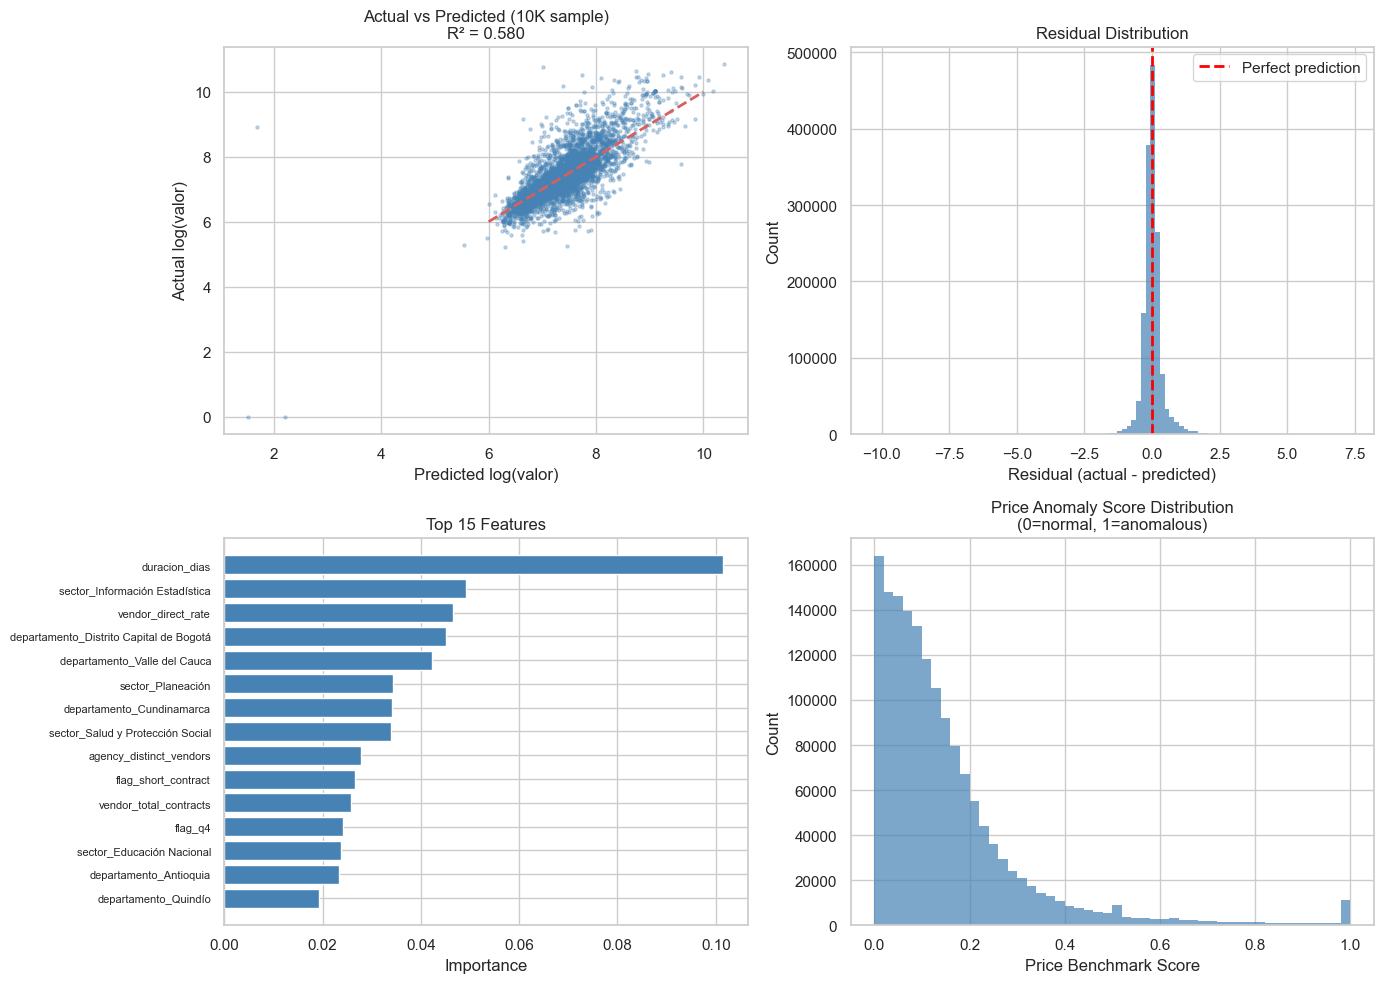

✅ Visualizations saved


In [26]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Actual vs Predicted
sample_idx = np.random.choice(len(fm), size=min(10000, len(fm)), replace=False)
axes[0, 0].scatter(fm.iloc[sample_idx]["predicted_log_valor"], 
                   fm.iloc[sample_idx]["log_valor"],
                   alpha=0.3, s=5, color="steelblue")
axes[0, 0].plot([6, 10], [6, 10], 'r--', linewidth=2)
axes[0, 0].set_xlabel("Predicted log(valor)")
axes[0, 0].set_ylabel("Actual log(valor)")
axes[0, 0].set_title(f"Actual vs Predicted (10K sample)\nR² = {r2_score(y_valid, model.predict(X_valid)):.3f}")

# 2. Residual distribution
axes[0, 1].hist(fm["residual_log"], bins=100, color="steelblue", edgecolor="none", alpha=0.7)
axes[0, 1].axvline(0, color="red", linestyle="--", linewidth=2, label="Perfect prediction")
axes[0, 1].set_xlabel("Residual (actual - predicted)")
axes[0, 1].set_ylabel("Count")
axes[0, 1].set_title("Residual Distribution")
axes[0, 1].legend()

# 3. Feature importance (top 15)
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)
axes[1, 0].barh(range(len(importance)), importance.values, color="steelblue")
axes[1, 0].set_yticks(range(len(importance)))
axes[1, 0].set_yticklabels(importance.index, fontsize=8)
axes[1, 0].set_xlabel("Importance")
axes[1, 0].set_title("Top 15 Features")
axes[1, 0].invert_yaxis()

# 4. Price benchmark score distribution
axes[1, 1].hist(fm["price_benchmark_score"], bins=50, color="steelblue", edgecolor="none", alpha=0.7)
axes[1, 1].set_xlabel("Price Benchmark Score")
axes[1, 1].set_ylabel("Count")
axes[1, 1].set_title("Price Anomaly Score Distribution\n(0=normal, 1=anomalous)")

plt.tight_layout()
plt.savefig("../outputs/charts/07_price_benchmarking.png", dpi=150)
plt.show()

print("✅ Visualizations saved")

In [27]:
# Save results - merge back with network_scores to preserve all columns
price_cols = [
    "id_contrato", "predicted_log_valor", "predicted_valor",
    "residual_log", "residual_pct", "price_benchmark_score",
    "flag_overpriced"
]

# Save standalone price scores
fm[price_cols].to_parquet(
    DATA_PROCESSED / "price_benchmark_scores.parquet",
    index=False,
    compression="snappy"
)

# Merge price score into main dataframe for next notebook
network_df = pd.read_parquet(DATA_PROCESSED / "network_scores.parquet")
final_df = network_df.merge(
    fm[["id_contrato", "price_benchmark_score", "flag_overpriced"]],
    on="id_contrato",
    how="left"
)

# Save as price_integrated for next notebook
final_df.to_parquet(
    DATA_PROCESSED / "price_integrated.parquet",
    index=False,
    compression="snappy"
)

# Export price anomaly contracts to CSV
anomaly_export = fm[fm["flag_overpriced"] == 1][[
    "id_contrato", "codigo_entidad", "nombre_entidad", "codigo_proveedor",
    "sector", "departamento", "valor_del_contrato", "predicted_valor",
    "residual_log", "residual_pct", "price_benchmark_score", "is_direct", "is_modified"
]].copy()

if "proxy_strong" in fm.columns:
    anomaly_export["proxy_strong"] = fm.loc[anomaly_export.index, "proxy_strong"]

anomaly_export = anomaly_export.sort_values("price_benchmark_score", ascending=False)
anomaly_export.to_csv("../outputs/tables/price_anomaly_contracts.csv", index=False)

print("=" * 70)
print("✅ PRICE BENCHMARKING COMPLETE")
print("=" * 70)
print(f"  Contracts scored:            {len(fm):,}")
print(f"  R² (validation):             {r2_score(y_valid, model.predict(X_valid)):.3f}")
print(f"  RMSE (validation):           {np.sqrt(mean_squared_error(y_valid, model.predict(X_valid))):.3f}")
print(f"  Price anomalies flagged:     {fm['flag_overpriced'].sum():,} ({fm['flag_overpriced'].mean()*100:.1f}%)")
print(f"  Anomalous contract spend:    {overpriced_spend/1e12:.2f} trillion COP")
print(f"  Correlation with proxy:      {corr:.4f}" if 'corr' in locals() else "")
print(f"\n  Fixes applied:")
print(f"    - Sector-aware normalization (hospitals vs hospitals)")
print(f"    - Absolute residuals (catches over AND underpricing)")
print(f"    - Direct award interaction (×1.0 direct, ×0.5 competitive)")
print(f"    - Removed leaky features (vendor spend aggregates)")
print(f"\n  Saved scores:                data/processed/price_benchmark_scores.parquet")
print(f"  Saved integrated:            data/processed/price_integrated.parquet")
print(f"  Saved CSV:                   outputs/tables/price_anomaly_contracts.csv")
print("=" * 70)

✅ PRICE BENCHMARKING COMPLETE
  Contracts scored:            1,553,594
  R² (validation):             0.580
  RMSE (validation):           0.350
  Price anomalies flagged:     76,420 (4.9%)
  Anomalous contract spend:    291.27 trillion COP
  Correlation with proxy:      0.0123

  Fixes applied:
    - Sector-aware normalization (hospitals vs hospitals)
    - Absolute residuals (catches over AND underpricing)
    - Direct award interaction (×1.0 direct, ×0.5 competitive)
    - Removed leaky features (vendor spend aggregates)

  Saved scores:                data/processed/price_benchmark_scores.parquet
  Saved integrated:            data/processed/price_integrated.parquet
  Saved CSV:                   outputs/tables/price_anomaly_contracts.csv
